# ML Olympiad - Quality Education


In [1]:
# from IPython import display
# display.Image("C:\Users\uiuiu\Pictures\enem_imagem.png")

### Todo:Imagem do Enem!

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Primeiro Passo: Análise dos Dados
#### Após lermos o banco de dados, iremos fazer um estudo sobre os dados para adquirirmos novas informações, procurando observar como as features se relacionam e o nível de inclusisão que o ENEM possui atualmente.

In [3]:
path = './Downloads/qualityeducation/train.csv'

df = pd.read_csv(path)
df.head()



,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31.0,F,0,1,1,...,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23.0,F,1,3,1,...,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17.0,M,0,3,1,...,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,2506301,Guarabira,25,PB,16.0,M,1,1,1,...,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,2304400,Fortaleza,23,CE,19.0,M,1,1,1,...,B,A,A,E,B,B,C,B,B,B


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311925 entries, 0 to 3311924
Columns: 118 entries, NU_INSCRICAO to Q025
dtypes: float64(16), int64(68), object(34)
memory usage: 2.9+ GB


In [5]:
# df.describe() # não faz sentido chamar o describe() em todo o df pois há colunas em excesso para serem analisadas

# Agrupando as colunas para facilitar o trabalho:

In [6]:
notas = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']

### Mini glossário com todas as colunas que eu vou usar, e pq acho que elas serão úteis.

- **Q006** = Pergunta referente a renda da família do candidato -> Transformei em 'renda_familiar'
- **TP_SEXO** = Masculino/Feminino
- **NU_IDADE** = Idade
- **TP_COR_RACA** = Cor/raça 
- **TP_ESCOLA** = Não Respondeu, pública, privada, exterior


In [7]:
dicionario_renda = {
    'A': 400    ,
    'B': 998    ,
    'C': 1497   ,
    'D': 1996    ,
    'E': 2495    ,
    'F': 2994    ,
    'G': 3992    ,
    'H': 4990    ,
    'I': 5988    ,
    'J': 6986    ,
    'K': 7984    ,
    'L': 8982    ,
    'M': 9980    ,
    'N': 11976   ,
    'O': 14970   ,
    'P': 19960   ,
    'Q': 25000  
}

df['renda_familiar'] = df.Q006.replace(dicionario_renda)

In [8]:
df['Nota_media'] = df[notas].mean(axis=1)
df['Nota_media']

0          508.02
1          459.82
2          521.90
3          476.36
4          703.04
            ...  
3311920    506.62
3311921    539.14
3311922    458.14
3311923       NaN
3311924    672.92
Name: Nota_media, Length: 3311925, dtype: float64

## Percebe-se que a feature mais correlacionada com a nota do candidato é a sua renda!!!

In [9]:
df_compacto = df[['renda_familiar','TP_SEXO','NU_IDADE','TP_COR_RACA','TP_ESCOLA','Nota_media']]
df_compacto.corr()

,renda_familiar,NU_IDADE,TP_COR_RACA,TP_ESCOLA,Nota_media
renda_familiar,1.000000,-0.096350,-0.215902,0.117413,0.401322
NU_IDADE,-0.096350,1.000000,0.054164,-0.313088,-0.138981
TP_COR_RACA,-0.215902,0.054164,1.000000,-0.059758,-0.199933
TP_ESCOLA,0.117413,-0.313088,-0.059758,1.000000,0.078181
Nota_media,0.401322,-0.138981,-0.199933,0.078181,1.000000


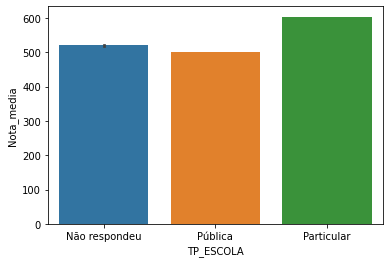

In [10]:
sns.barplot(data=df, x = df['TP_ESCOLA'].map({1:'Não respondeu',2:'Pública',3:'Particular'}), y ='Nota_media');

#### Verificando a quantidade de nans em cada coluna, percebe-se que algumas colunas não possuem uma quantidade significante de dados válidos, mas a maior parte das features estão completas ou praticamente completas

In [11]:
df.isna().sum().sort_values(ascending=False).head(20)

CO_MUNICIPIO_ESC           2566547
TP_SIT_FUNC_ESC            2566547
TP_LOCALIZACAO_ESC         2566547
TP_DEPENDENCIA_ADM_ESC     2566547
SG_UF_ESC                  2566547
CO_UF_ESC                  2566547
NO_MUNICIPIO_ESC           2566547
CO_ESCOLA                  2566547
TP_ENSINO                  1441571
NU_NOTA_MT                  900794
NU_NOTA_CN                  900794
TP_STATUS_REDACAO           762324
NU_NOTA_REDACAO             762324
NU_NOTA_LC                  762323
NU_NOTA_CH                  762323
Nota_media                  756941
NO_MUNICIPIO_NASCIMENTO      94562
CO_MUNICIPIO_NASCIMENTO      94562
SG_UF_NASCIMENTO             94562
CO_UF_NASCIMENTO             94562
dtype: int64

# TODO: Fazer um gráfico de mapa mostrando a distribuição de candidatos por estado, e também fazer um com a diferença das notas, podendo vir conciliado com a renda média daquele estado.

In [12]:
df.SG_UF_RESIDENCIA.value_counts(True)
# mesmo resultado das amostras coletadas

SP    0.159802
MG    0.105650
BA    0.078140
RJ    0.066369
CE    0.058209
PA    0.055477
PE    0.053315
MA    0.043054
RS    0.042890
PR    0.041300
GO    0.033369
PB    0.028950
PI    0.023805
RN    0.023455
AM    0.023148
SC    0.021539
ES    0.020006
DF    0.018485
AL    0.017960
MT    0.017316
SE    0.014911
MS    0.013751
RO    0.011548
TO    0.009258
AP    0.008263
AC    0.007494
RR    0.002538
Name: SG_UF_RESIDENCIA, dtype: float64

### Verificando a variação das notas por raça/cor, sendo 1 referente aos brancos e 5 aos indígenas, entretanto, como será visto mais a frente, essa diferença - mesmo que pequena - pode ser explicada pela diferença na renda média dessas classes. Mais a frente também será verificado como a renda é um fator extremamente impactante na nota final do candidato.

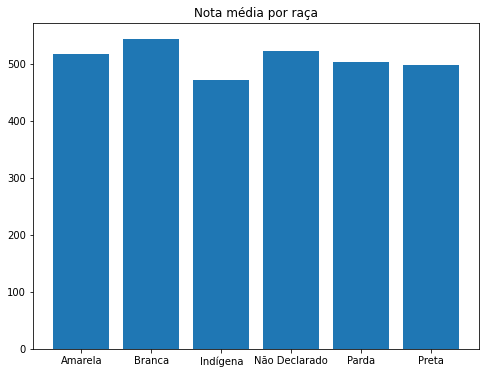

In [40]:
df['TP_COR_RACA'] = df.TP_COR_RACA.replace({0:'Não Declarado',1:'Branca',2:'Preta',3:'Parda',4:'Amarela',5:'Indígena'})
teste = df.groupby('TP_COR_RACA')['Nota_media'].mean()
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(teste.index,teste.values)
plt.title('Nota média por raça')
plt.show()

#### Percebe-se que existe uma correlação clara entre a renda familiar média de uma raça com a sua nota esperada!

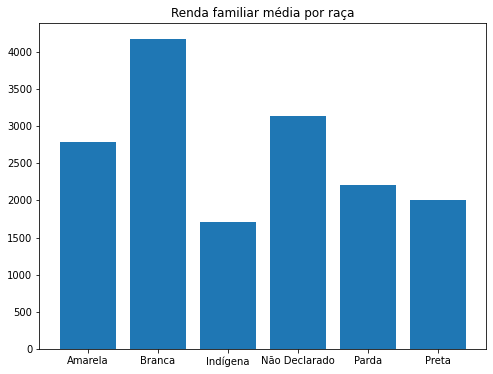

In [41]:
renda_media_cor = df.groupby('TP_COR_RACA')['renda_familiar'].mean()
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(renda_media_cor.index,renda_media_cor.values)
plt.title('Renda familiar média por raça')
plt.show()

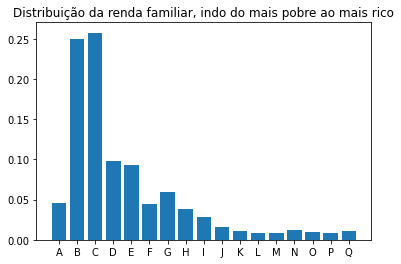

In [43]:
distribuição_renda = df.Q006.value_counts(True).sort_index()
plt.bar(distribuição_renda.index,distribuição_renda.values)
plt.title('Distribuição da renda familiar, indo do mais pobre ao mais rico')
plt.show()

## Pensando na possibilidade de fazer uma exploração mais ágil dos dados, consideramos usar apenas uma amostra dos dados de treino para a análise de dados inicial.

In [19]:
path = './Downloads/amostra.csv'

df_a = pd.read_csv(path)
df_a.head()

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,78cdc39d-ba42-4242-b435-55ad9138ac68,1100205,Porto Velho,11,RO,26.0,F,1,3,1,...,A,A,A,B,A,A,D,A,A,A
1,ba374119-0c61-4bde-a080-dd385d48e5a5,5300108,Brasília,53,DF,18.0,F,1,3,1,...,B,A,A,B,A,A,E,B,B,B
2,23d88f79-c6c7-4c78-9eb1-a6cde20d889f,2111300,São Luís,21,MA,18.0,F,1,3,1,...,A,A,A,B,B,A,D,A,A,A
3,6a738649-bd5c-4d6a-83a4-d0f36ecd7a76,4125506,São José dos Pinhais,41,PR,30.0,F,1,3,1,...,A,A,A,B,A,A,C,A,B,B
4,de6f0960-bc40-417b-aabc-1c64b7ee2898,2203404,Dom Expedito Lopes,22,PI,19.0,M,1,1,1,...,B,A,A,C,B,A,E,A,C,B


In [23]:
Variaveis_Atendimento_Especializado = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']

In [25]:
for x in Variaveis_Atendimento_Especializado:
    for y in notas:
        sns.boxplot(data = df_a, x = x, y = y )
        plt.show()

### Para a minha supresa, pessoa com 'Défict de Atenção' e 'Outra Deficiência' tiveram notas melhores do que quem não possui tais características.Falar dos 60 minutos extras, ritalina, e tenho q verificar se a diferença entre quem tem tdah e é pobre ou rico eh maior doq do pobre p rico no geral, pois isso poderia indicar que os ricos estão forgando o exame para ganhar os 60 minutos e talvez pela ritalina tb!!!

In [28]:
df_tdah = df[['IN_DEFICIT_ATENCAO','NU_NOTA_REDACAO','Q006']].sort_values('Q006')
df_tdah

,IN_DEFICIT_ATENCAO,NU_NOTA_REDACAO,Q006
664367,0,780.0,A
3061726,0,NaN,A
3061717,0,360.0,A
3061714,0,NaN,A
532407,0,NaN,A
...,...,...,...
1601044,0,660.0,Q
1601067,0,880.0,Q
646929,0,960.0,Q
3175834,0,940.0,Q


In [29]:
plt.figure(figsize=(10,10))
sns.barplot(data=df_tdah, x = 'Q006', y ='NU_NOTA_REDACAO', hue = 'IN_DEFICIT_ATENCAO');

### O que é observado:
#### 1: Quanto mais rica a sua família, menos relevante é o fato de vc ter TDAH

### Questionamento: Por que ter TDAH eleva tanto a nota dos candidatos?
#### 1: Alunos tomando ritalina como doping?
#### 2: 60 minutos adicionais para fazer a prova?



## Para descobrir se as pessoas com TDAH estavam tendo notas superiores por conta da ritalina, fizemos uma comparação entre as pessoas que tem dislexia e não tem TDAH com as pessoas que tem os dois, uma vez que apenas o segundo grupo toma ritalina - remédio conhecido por aumentar o foco dos estudantes.

In [31]:
dislexia_pura = df[(df.IN_DISLEXIA==1) & (df.IN_DEFICIT_ATENCAO==1)].index
df_dislexia_sem_tdah = df.drop(index = dislexia_pura)

dislexia_com_tdah = df[(df.IN_DISLEXIA==1) & (df.IN_DEFICIT_ATENCAO==0)].index
df_dislexia_com_tdah = df.drop(index = dislexia_com_tdah)

In [32]:
for nota in notas:
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,8))
    fig.suptitle(f'Nota: {nota}')

    sns.barplot(data=df_dislexia_sem_tdah, x = 'Q006', y = nota, hue = 'IN_DISLEXIA', ax = ax1);
    ax1.set_title('Dislexia Pura')

    sns.barplot(data=df_dislexia_com_tdah, x = 'Q006', y = nota, hue = 'IN_DISLEXIA', ax = ax2);
    ax2.set_title('Dislexia com TDAH')
    
    plt.savefig(f'Influência da Dislexia - {nota}')
    plt.show()

### Observando os resultados, é questionável que os candidatos que possuem TDAH devem receber um atendimento diferenciado, pois aparentemente o tratamento que eles recebem - acompanhamento psicológico e medicação - já seria suficiente para alcançar o mesmo desenpenho dos candidatos sem TDAH, e por consequência o atendimento especializado seria responsável por esse desenpenho superior em todas as provas.

# Machine Learning

### Importação da amostra de 10% da base

In [2]:
amostra = pd.read_csv('amostra.csv')
amostra

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,78cdc39d-ba42-4242-b435-55ad9138ac68,1100205,Porto Velho,11,RO,26.0,F,1,3,1,...,A,A,A,B,A,A,D,A,A,A
1,ba374119-0c61-4bde-a080-dd385d48e5a5,5300108,Brasília,53,DF,18.0,F,1,3,1,...,B,A,A,B,A,A,E,B,B,B
2,23d88f79-c6c7-4c78-9eb1-a6cde20d889f,2111300,São Luís,21,MA,18.0,F,1,3,1,...,A,A,A,B,B,A,D,A,A,A
3,6a738649-bd5c-4d6a-83a4-d0f36ecd7a76,4125506,São José dos Pinhais,41,PR,30.0,F,1,3,1,...,A,A,A,B,A,A,C,A,B,B
4,de6f0960-bc40-417b-aabc-1c64b7ee2898,2203404,Dom Expedito Lopes,22,PI,19.0,M,1,1,1,...,B,A,A,C,B,A,E,A,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331187,07904ae4-9c4d-447f-857c-7ecf7e44f5d8,4120002,Porecatu,41,PR,22.0,F,1,1,1,...,B,A,B,B,B,A,C,B,B,B
331188,56fce69f-a533-4c37-84db-9d5231897ebf,2206605,Monte Alegre do Piauí,22,PI,25.0,F,1,3,1,...,A,A,A,A,A,A,A,A,A,A
331189,97029c31-e2aa-496b-83c8-7cd8d9cedb3a,5212808,Mara Rosa,52,GO,19.0,F,1,1,1,...,B,A,B,B,B,A,C,A,B,B
331190,4a60da0d-993d-4fd9-a28d-c49ad9510751,2504355,Caturité,25,PB,22.0,M,1,3,1,...,A,A,A,C,A,A,B,A,B,A


Importações para modelo

In [3]:
!pip install xgboost

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold

In [4]:
lista_targets = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
df_model_baseline = amostra.dropna(axis=0)

X = df_model_baseline.drop(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_INSCRICAO'], axis = 1)
y = df_model_baseline[lista_targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [5]:
# ============================================
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================

pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                              ("label", OneHotEncoder(handle_unknown='ignore'))])

features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

# ==========================================================

pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat", pipe_features_cat, features_cat)])

Modelo - GradientBoosting

In [7]:
model = MultiOutputRegressor(GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                                       criterion='friedman_mse', min_samples_split=2,
                                                       min_samples_leaf=1,
                                                       min_weight_fraction_leaf=0.0, max_depth=3,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None, init=None, random_state=None,
                                                       max_features=None,
                                                       alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                                       validation_fraction=0.1, n_iter_no_change=None, tol=0.0001,
                                                       ccp_alpha=0.0))

pipe = Pipeline([("pre_processador", pre_processador),
                 ("modelo", model)])

hyperparameters = dict(modelo__estimator__learning_rate=[0.05, 0.1, 0.2, 0.5, 0.9], modelo__estimator__loss=['ls', 'lad', 'huber'],
                       modelo__estimator__n_estimators=[20, 50, 100, 200, 300, 500, 700, 1000],
                       modelo__estimator__criterion=['friedman_mse', 'mse'], modelo__estimator__min_samples_split=[2, 4, 7, 10],
                       modelo__estimator__max_depth=[3, 5, 10, 15, 20, 30], modelo__estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
                       modelo__estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
                       modelo__estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300])

randomized_search = RandomizedSearchCV(pipe, hyperparameters, random_state=10, n_iter=5, scoring = 'neg_root_mean_squared_error',
                                       n_jobs=-1, refit=True, cv=5, verbose=10,
                                       pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_model = hyperparameters_tuning.best_estimator_

print(tuned_model.predict(X_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters = {'modelo__estimator__n_estimators': 300, 'modelo__estimator__min_samples_split': 2, 'modelo__estimator__min_samples_leaf': 2, 'modelo__estimator__min_impurity_decrease': 0.2, 'modelo__estimator__max_leaf_nodes': 5, 'modelo__estimator__max_depth': 3, 'modelo__estimator__loss': 'huber', 'modelo__estimator__learning_rate': 0.5, 'modelo__estimator__criterion': 'mse'}
[[477.14534338 536.61918526 538.83993808 536.38106977 606.23261469]
 [446.0855488  500.22568798 522.18741278 503.21957311 502.82469415]
 [589.73871336 594.88490272 592.26507157 631.05807904 764.24261835]
 ...
 [432.50469408 468.16635843 483.41800325 463.31916414 539.72801995]
 [565.41685847 594.59840876 584.34105132 660.96025997 692.65383675]
 [486.76140155 546.52011641 566.47373148 526.78336881 618.66898376]]


In [7]:
from joblib import dump, load
#dump(tuned_model, 'GradientBoosting.joblib') 

In [13]:
y_pred = tuned_model.predict(X_test)
print(f'Erro de Teste: {sqrt(mse(y_test, y_pred))}')

Erro de Teste: 84.46433604492611


Modelo XGBRegressor

In [6]:
model = MultiOutputRegressor(XGBRegressor(n_jobs=-1))

pipe = Pipeline([("pre_processador", pre_processador),
                 ("modelo", model)])

hyperparameters = dict(modelo__estimator__n_estimators= [400, 700, 1000],
                       modelo__estimator__colsample_bytree=[0.7, 0.8],
                       modelo__estimator__max_depth=[15,20,25],
                       modelo__estimator__reg_alpha=[1.1, 1.2, 1.3],
                       modelo__estimator__reg_lambda= [1.1, 1.2, 1.3],
                       modelo__estimator__subsample= [0.7, 0.8, 0.9])


randomized_search = RandomizedSearchCV(pipe, hyperparameters, random_state=10, n_iter=5, scoring = 'neg_root_mean_squared_error',
                                       n_jobs=-1, refit=True, cv=5, verbose=10,
                                       pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

tuned_modelXGB = hyperparameters_tuning.best_estimator_

print(tuned_modelXGB.predict(X_test))


# Root Mean Squared Error

print(tuned_modelXGB.best_params_)
dump(tuned_modelXGB, 'XGB.joblib') 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters = {'modelo__estimator__subsample': 0.9, 'modelo__estimator__reg_lambda': 1.3, 'modelo__estimator__reg_alpha': 1.2, 'modelo__estimator__n_estimators': 1000, 'modelo__estimator__max_depth': 15, 'modelo__estimator__colsample_bytree': 0.8}
[[471.57614 531.10376 522.278   487.3859  640.10645]
 [460.0084  494.69565 515.47626 485.60654 545.0146 ]
 [672.2729  610.2022  613.1792  699.91437 726.2989 ]
 ...
 [441.92383 525.1621  455.24884 432.31265 528.6545 ]
 [567.14386 608.4065  586.58215 630.9538  785.5007 ]
 [507.20978 508.86197 549.4091  453.8138  558.8375 ]]


AttributeError: 'Pipeline' object has no attribute 'best_score_'

In [10]:
dump(tuned_modelXGB, 'XGB.joblib') 

['XGB.joblib']

In [8]:
xgb = load('XGB.joblib')

In [22]:
y_pred = xgb.predict(X_test)
print(f'Erro de Teste: {sqrt(mse(y_test, y_pred))}')

Erro de Teste: 90.0557919889587


In [14]:
print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

Best Parameters = {'modelo__estimator__subsample': 0.9, 'modelo__estimator__reg_lambda': 1.3, 'modelo__estimator__reg_alpha': 1.2, 'modelo__estimator__n_estimators': 1000, 'modelo__estimator__max_depth': 15, 'modelo__estimator__colsample_bytree': 0.8}


Considerando que dentre os dois ensemble o melhor modelo foi o Gradient Boosting Regressor, usaremos ele para fazer nossas previsões

In [23]:
GBR = load('GradientBoosting.joblib')

In [24]:
test = pd.read_csv('test.csv')

X_entrega = test.drop(['NU_INSCRICAO'], axis = 1)

y_pred_entrega = GBR.predict(X_entrega)



In [25]:
y_pred_entrega

array([[432.21620338, 455.04716867, 485.73189916, 475.92576185,
        583.49242568],
       [477.24353672, 513.51722328, 540.80086498, 494.36354377,
        604.13530569],
       [505.32981217, 526.1446369 , 532.82742361, 552.92792828,
        758.44753661],
       ...,
       [469.94418533, 491.55949216, 475.41504844, 459.75579961,
        465.86290533],
       [448.58734625, 489.23378084, 510.14137412, 488.61018746,
        573.19326273],
       [473.04877827, 508.53404855, 523.30148385, 525.76791842,
        552.58276052]])

In [26]:
submission_vazio = pd.read_csv('sample_submission.csv')
submission_vazio

,NU_INSCRICAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,5d5b362b-7388-4ac6-81b3-23573e4e2d3a,0,0,0,0,0
1,52356efd-3239-4cd2-a444-416625dfc560,0,0,0,0,0
2,1ba42e9a-dd61-4405-9b08-79b728ad23c9,0,0,0,0,0
3,16fa0f84-a88f-43e6-bcbb-8d5ea41e5f03,0,0,0,0,0
4,fa663d11-5052-4ab2-b771-3a3de3bdec55,0,0,0,0,0
...,...,...,...,...,...,...
1783340,51bb5120-7369-46d3-8bae-0070891f8af4,0,0,0,0,0
1783341,c8f3cc53-1009-484c-9a67-1d548b9d01e8,0,0,0,0,0
1783342,5fc43159-40ae-4b09-b633-2428a0535a94,0,0,0,0,0
1783343,a96bdbdc-0492-40c7-932d-2e656ff86b5c,0,0,0,0,0


In [27]:
df_entrega =pd.DataFrame(y_pred_entrega)
df_entrega

,0,1,2,3,4
0,432.216203,455.047169,485.731899,475.925762,583.492426
1,477.243537,513.517223,540.800865,494.363544,604.135306
2,505.329812,526.144637,532.827424,552.927928,758.447537
3,490.853563,508.745437,532.008600,542.915890,577.084150
4,526.984535,546.970519,547.559296,591.508788,629.243204
...,...,...,...,...,...
1783340,471.074406,503.663201,515.439618,519.205430,587.698547
1783341,441.735385,424.536357,446.999368,462.769060,466.971541
1783342,469.944185,491.559492,475.415048,459.755800,465.862905
1783343,448.587346,489.233781,510.141374,488.610187,573.193263


In [28]:
df_entrega['NU_INSCRICAO'] = submission_vazio['NU_INSCRICAO']
df_entrega

,0,1,2,3,4,NU_INSCRICAO
0,432.216203,455.047169,485.731899,475.925762,583.492426,5d5b362b-7388-4ac6-81b3-23573e4e2d3a
1,477.243537,513.517223,540.800865,494.363544,604.135306,52356efd-3239-4cd2-a444-416625dfc560
2,505.329812,526.144637,532.827424,552.927928,758.447537,1ba42e9a-dd61-4405-9b08-79b728ad23c9
3,490.853563,508.745437,532.008600,542.915890,577.084150,16fa0f84-a88f-43e6-bcbb-8d5ea41e5f03
4,526.984535,546.970519,547.559296,591.508788,629.243204,fa663d11-5052-4ab2-b771-3a3de3bdec55
...,...,...,...,...,...,...
1783340,471.074406,503.663201,515.439618,519.205430,587.698547,51bb5120-7369-46d3-8bae-0070891f8af4
1783341,441.735385,424.536357,446.999368,462.769060,466.971541,c8f3cc53-1009-484c-9a67-1d548b9d01e8
1783342,469.944185,491.559492,475.415048,459.755800,465.862905,5fc43159-40ae-4b09-b633-2428a0535a94
1783343,448.587346,489.233781,510.141374,488.610187,573.193263,a96bdbdc-0492-40c7-932d-2e656ff86b5c


In [29]:
df_entrega.columns = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO', 'NU_INSCRICAO']
df_entrega = df_entrega.set_index('NU_INSCRICAO').reset_index()

In [30]:
submission = submission_vazio.merge(df_entrega,how='inner', on = 'NU_INSCRICAO')

In [31]:
submission.drop(columns = ['NU_NOTA_CN_x','NU_NOTA_CH_x','NU_NOTA_LC_x','NU_NOTA_MT_x','NU_NOTA_REDACAO_x'],inplace = True)
submission

,NU_INSCRICAO,NU_NOTA_CN_y,NU_NOTA_CH_y,NU_NOTA_LC_y,NU_NOTA_MT_y,NU_NOTA_REDACAO_y
0,5d5b362b-7388-4ac6-81b3-23573e4e2d3a,432.216203,455.047169,485.731899,475.925762,583.492426
1,52356efd-3239-4cd2-a444-416625dfc560,477.243537,513.517223,540.800865,494.363544,604.135306
2,1ba42e9a-dd61-4405-9b08-79b728ad23c9,505.329812,526.144637,532.827424,552.927928,758.447537
3,16fa0f84-a88f-43e6-bcbb-8d5ea41e5f03,490.853563,508.745437,532.008600,542.915890,577.084150
4,fa663d11-5052-4ab2-b771-3a3de3bdec55,526.984535,546.970519,547.559296,591.508788,629.243204
...,...,...,...,...,...,...
1783340,51bb5120-7369-46d3-8bae-0070891f8af4,471.074406,503.663201,515.439618,519.205430,587.698547
1783341,c8f3cc53-1009-484c-9a67-1d548b9d01e8,441.735385,424.536357,446.999368,462.769060,466.971541
1783342,5fc43159-40ae-4b09-b633-2428a0535a94,469.944185,491.559492,475.415048,459.755800,465.862905
1783343,a96bdbdc-0492-40c7-932d-2e656ff86b5c,448.587346,489.233781,510.141374,488.610187,573.193263


In [32]:
submission.columns = ['NU_INSCRICAO','NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO']
submission

,NU_INSCRICAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,5d5b362b-7388-4ac6-81b3-23573e4e2d3a,432.216203,455.047169,485.731899,475.925762,583.492426
1,52356efd-3239-4cd2-a444-416625dfc560,477.243537,513.517223,540.800865,494.363544,604.135306
2,1ba42e9a-dd61-4405-9b08-79b728ad23c9,505.329812,526.144637,532.827424,552.927928,758.447537
3,16fa0f84-a88f-43e6-bcbb-8d5ea41e5f03,490.853563,508.745437,532.008600,542.915890,577.084150
4,fa663d11-5052-4ab2-b771-3a3de3bdec55,526.984535,546.970519,547.559296,591.508788,629.243204
...,...,...,...,...,...,...
1783340,51bb5120-7369-46d3-8bae-0070891f8af4,471.074406,503.663201,515.439618,519.205430,587.698547
1783341,c8f3cc53-1009-484c-9a67-1d548b9d01e8,441.735385,424.536357,446.999368,462.769060,466.971541
1783342,5fc43159-40ae-4b09-b633-2428a0535a94,469.944185,491.559492,475.415048,459.755800,465.862905
1783343,a96bdbdc-0492-40c7-932d-2e656ff86b5c,448.587346,489.233781,510.141374,488.610187,573.193263


In [33]:
submission.to_csv('submissions_luiz_george.csv')